In [1]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')
import predictor.feature_extraction as fe
import utils.preprocessing as pp
import utils.misc as misc

Populating the interactive namespace from numpy and matplotlib


## In the previous notebook some hyperparameter exploration was made for the Random Forest Regressor. Let's see which are now the best predictors for each number of "ahead days".

In [24]:
best_raw_params = pd.read_pickle('../../data/best_dataset_params_raw_df.pkl')

def keep_max_r2(record):
    return record.loc[np.argmax(record['r2']),:]

best_ini_pred_df = best_raw_params.groupby('ahead_days').apply(keep_max_r2)
best_ini_pred_df

,GOOD_DATA_RATIO,SAMPLES_GOOD_DATA_RATIO,ahead_days,base_days,model,mre,r2,step_days,train_days,train_val_time,x_filename,y_filename
ahead_days,,,,,,,,,,,,
1.0,0.99,0.9,1.0,112.0,linear,0.015856,0.986599,7.0,504.0,-1.0,x_base112_ahead1.pkl,y_base112_ahead1.pkl
7.0,0.99,0.9,7.0,112.0,linear,0.042367,0.923348,7.0,756.0,-1.0,x_base112_ahead7.pkl,y_base112_ahead7.pkl
14.0,0.99,0.9,14.0,112.0,linear,0.060167,0.865259,7.0,756.0,-1.0,x_base112_ahead14.pkl,y_base112_ahead14.pkl
28.0,0.99,0.9,28.0,112.0,linear,0.091966,0.758046,7.0,756.0,-1.0,x_base112_ahead28.pkl,y_base112_ahead28.pkl
56.0,0.99,0.9,56.0,112.0,linear,0.127913,0.590426,7.0,756.0,-1.0,x_base112_ahead56.pkl,y_base112_ahead56.pkl


Those were the best predictors before the hyperparameters tuning

In [25]:
hyper1_df = pd.read_pickle('../../data/hyper_ahead1_random_forest_df.pkl')
hyper1_df

,n_estimators,max_depth,n_jobs,scores,r2,mre
0,50,5,-1,"(0.983814083021, 0.0191439772135)",0.983814,0.019144
1,50,10,-1,"(0.986125708821, 0.0168504555546)",0.986126,0.016850
2,100,5,-1,"(0.984182203771, 0.0190912449575)",0.984182,0.019091
3,100,10,-1,"(0.98606697491, 0.0168202507896)",0.986067,0.016820


In [26]:
from sklearn.metrics import r2_score

hyper_1_best_series = hyper1_df.iloc[np.argmax(hyper1_df['r2'])].copy()
hyper_1_best_series.name = 1
hyper_1_best_series

n_estimators                                   50
max_depth                                      10
n_jobs                                         -1
scores          (0.986125708821, 0.0168504555546)
r2                                       0.986126
mre                                     0.0168505
Name: 1, dtype: object

In [27]:
ahead_days = [1, 7, 14, 28, 56]
best_hyper_df = pd.DataFrame()
best_hyper_df.index.name = 'ahead_days'

for ahead in ahead_days:
    hyper_df = pd.read_pickle('../../data/hyper_ahead{}_random_forest_df.pkl'.format(ahead))
    hyper_best_series = hyper_df.iloc[np.argmax(hyper_df['r2'])].copy()
    hyper_best_series.name = ahead
    best_hyper_df = best_hyper_df.append(hyper_best_series)
best_hyper_df

,max_depth,mre,n_estimators,n_jobs,r2,scores
ahead_days,,,,,,
1,10.0,0.016850,50.0,-1.0,0.986126,"(0.986125708821, 0.0168504555546)"
7,5.0,0.042002,100.0,-1.0,0.929017,"(0.929016577116, 0.0420024748489)"
14,5.0,0.059515,100.0,-1.0,0.868927,"(0.868927025792, 0.0595149788733)"
28,5.0,0.090310,50.0,-1.0,0.765112,"(0.76511197092, 0.0903104492391)"
56,5.0,0.126410,50.0,-1.0,0.615412,"(0.615412026805, 0.126409538141)"


## Let's compare the new best Random Forest predictors with the old Linear Regressors.

In [28]:
def join_and_compare(df1, df2, column, labels):
    tj1 = pd.DataFrame(df1[column].copy())
    tj1.rename(columns = {column: labels[0]}, inplace=True)
    tj2 = pd.DataFrame(df2[column].copy())
    tj2.rename(columns = {column: labels[1]}, inplace=True)
    comp_df = tj1.join(tj2)
    comp_df['diff'] = comp_df[labels[1]] - comp_df[labels[0]]
    
    return comp_df

### First the $r^2$ metrics

In [29]:
comp_r2_df = join_and_compare(best_ini_pred_df, best_hyper_df, 'r2', ['linear', 'random_forest'])
comp_r2_df['best'] = comp_r2_df.apply(lambda x: np.argmax(x), axis=1)
comp_r2_df

,linear,random_forest,diff,best
ahead_days,,,,
1.0,0.986599,0.986126,-0.000474,linear
7.0,0.923348,0.929017,0.005669,random_forest
14.0,0.865259,0.868927,0.003668,random_forest
28.0,0.758046,0.765112,0.007066,random_forest
56.0,0.590426,0.615412,0.024986,random_forest


The values are very similar in both cases. A minor difference can be seen only in the case of 56 days ahead, in which the random forest seems to be a bit better than the linear predictor. In any case, as the linear predictor is much simpler, and faster, it's probably better to keep it as the best predictor. It can be seen that this scenario is different from the one before hyperparameter tuning, in which the linear predictor was always better.

### And then the MRE metrics

In [30]:
comp_mre_df = join_and_compare(best_ini_pred_df, best_hyper_df, 'mre', ['linear', 'random_forest'])
comp_mre_df['best'] = comp_mre_df.apply(lambda x: np.argmax(x), axis=1)
comp_mre_df

,linear,random_forest,diff,best
ahead_days,,,,
1.0,0.015856,0.016850,0.000994,random_forest
7.0,0.042367,0.042002,-0.000365,linear
14.0,0.060167,0.059515,-0.000652,linear
28.0,0.091966,0.090310,-0.001656,linear
56.0,0.127913,0.126410,-0.001504,linear


The values for the MRE metrics are almost the same for both predictors.

## Conlcusion: The linear predictor will be chosen for all the predictions. In the case of the 56 ahead days prediction, a better $r^2$ metric could be achieved by the random forest predictor, but the linear predictor is still far simpler and faster.

# Testing the chosen predictor

### Let's get the test data

In [31]:
data_test_df = pd.read_pickle('../../data/data_test_df.pkl')
data_test_df.head()

feature      Close                                                           \
               SPY     MMM    ABT   ABBV    ACN   ATVI     AYI   ADBE   AMD   
date                                                                          
2015-01-02  205.43  164.06  44.90  65.89  88.84  20.13  139.88  72.34   NaN   
2015-01-05  201.72  160.36  44.91  64.65  87.34  19.85  136.52  71.98  2.66   
2015-01-06  199.82  158.65  44.40  64.33  86.71  19.48  134.81  70.53  2.63   
2015-01-07  202.31  159.80  44.76  66.93  88.53  19.06  137.20  71.11  2.58   
2015-01-08  205.90  163.63  45.68  67.63  89.88  19.25  142.00  72.92  2.61   

feature               ...         Volume                                       \
               AAP    ...            XEL        XRX       XLNX  XL        XYL   
date                  ...                                                       
2015-01-02  158.56    ...      2535289.0  3912022.0  2402443.0 NaN   606118.0   
2015-01-05  156.47    ...      3107187.0  7032861.0  2611059.0 NaN  1369903.0   
2015-01-06  156.36    ...      4749648.0  7170289.0  3430462.0 NaN  1336249.0   
2015-01-07  159.72    ...      2833770.0  4836408.0  2110610.0 NaN  1039030.0   
2015-01-08  161.12    ...      2516764.0  6229982.0  2824232.0 NaN   821836.0   

feature                                                             
                  YHOO        YUM        ZBH       ZION        ZTS  
date                                                                
2015-01-02  11924473.0  1641557.0   909491.0  2299118.0  1784851.0  
2015-01-05  14389308.0  3176619.0  2163761.0  5326879.0  3116681.0  
2015-01-06  16204304.0  3597727.0  1782098.0  9096223.0  3987015.0  
2015-01-07  11788031.0  3273992.0  1462026.0  2759850.0  2481935.0  
2015-01-08  14704771.0  3061324.0  1408433.0  1831484.0  3121258.0  

[5 rows x 2495 columns]

When generating the datasets, some symbols were removed from the training set (because they contained too many missing points). The same symbols should be removed from the test set.

### Let's generate datasets for the test set, with the best parameters found.

In [33]:
best_ini_pred_df

,GOOD_DATA_RATIO,SAMPLES_GOOD_DATA_RATIO,ahead_days,base_days,model,mre,r2,step_days,train_days,train_val_time,x_filename,y_filename
ahead_days,,,,,,,,,,,,
1.0,0.99,0.9,1.0,112.0,linear,0.015856,0.986599,7.0,504.0,-1.0,x_base112_ahead1.pkl,y_base112_ahead1.pkl
7.0,0.99,0.9,7.0,112.0,linear,0.042367,0.923348,7.0,756.0,-1.0,x_base112_ahead7.pkl,y_base112_ahead7.pkl
14.0,0.99,0.9,14.0,112.0,linear,0.060167,0.865259,7.0,756.0,-1.0,x_base112_ahead14.pkl,y_base112_ahead14.pkl
28.0,0.99,0.9,28.0,112.0,linear,0.091966,0.758046,7.0,756.0,-1.0,x_base112_ahead28.pkl,y_base112_ahead28.pkl
56.0,0.99,0.9,56.0,112.0,linear,0.127913,0.590426,7.0,756.0,-1.0,x_base112_ahead56.pkl,y_base112_ahead56.pkl


In [34]:
best_ini_pred_df.to_pickle('../../data/best_params_final_df.pkl')

Some playing with the data to remove the same symbols as in the training set

In [54]:
params = best_ini_pred_df.loc[1]

In [55]:
train_val_time = int(params['train_val_time'])
base_days = int(params['base_days'])
step_days = int(params['step_days'])
ahead_days = int(params['ahead_days'])
    
print('Generating: base{}_ahead{}'.format(base_days, ahead_days))
pid = 'base{}_ahead{}'.format(base_days, ahead_days)

Generating: base112_ahead1


In [56]:
y_train_df = pd.read_pickle('../../data/y_{}.pkl'.format(pid))
y_train_df.head()

1993-01-29  AAPL    0.945761
            ABT     1.416988
            ADBE    0.914591
            ADM     0.947878
            ADP     0.944196
Name: 112, dtype: float64

In [57]:
kept_symbols = y_train_df.index.get_level_values(1).unique().tolist()
len(kept_symbols)

285

In [58]:
len(data_test_df.columns.get_level_values(1).unique().tolist())

499

In [59]:
filtered_data_test_df = data_test_df.loc[:, (slice(None), kept_symbols)]

In [60]:
len(filtered_data_test_df.columns.get_level_values(1).unique().tolist())

285

### OK, let's create a function to generate one test dataset

In [62]:
def generate_one_test_set(params, data_df):
    # print(('-'*70 + '\n {}, {} \n' + '-'*70).format(params['base_days'].values, params['ahead_days'].values))
    tic = time()
    
    train_val_time = int(params['train_val_time'])
    base_days = int(params['base_days'])
    step_days = int(params['step_days'])
    ahead_days = int(params['ahead_days'])
    
    print('Generating: base{}_ahead{}'.format(base_days, ahead_days))
    pid = 'base{}_ahead{}'.format(base_days, ahead_days)
    
    # Getting the data
    today = data_df.index[-1]  # Real date
    print(pid + ') data_df loaded')

    # Drop symbols with many missing points
    y_train_df = pd.read_pickle('../../data/y_{}.pkl'.format(pid))
    kept_symbols = y_train_df.index.get_level_values(1).unique().tolist()
    data_df = data_df.loc[:, (slice(None), kept_symbols)]
    print(pid + ') Irrelevant symbols dropped.')
    
    # Generate the intervals for the predictor
    x, y = fe.generate_train_intervals(data_df, 
                                       train_val_time, 
                                       base_days, 
                                       step_days,
                                       ahead_days, 
                                       today, 
                                       fe.feature_close_one_to_one)    
    print(pid + ') Intervals generated')
    
    # Drop "bad" samples and fill missing data
    x_y_df = pd.concat([x, y], axis=1)
    x_y_df = pp.drop_irrelevant_samples(x_y_df, params['SAMPLES_GOOD_DATA_RATIO'])
    x = x_y_df.iloc[:, :-1]
    y = x_y_df.iloc[:, -1]
    x = pp.fill_missing(x)
    print(pid + ') Irrelevant samples dropped and missing data filled.')
    
    # Pickle that
    x.to_pickle('../../data/x_{}_test.pkl'.format(pid))
    y.to_pickle('../../data/y_{}_test.pkl'.format(pid))
    
    toc = time()
    print('%s) %i intervals generated in: %i seconds.' % (pid, x.shape[0], (toc-tic)))
    
    return pid, x, y

In [64]:
for ind in range(best_ini_pred_df.shape[0]):
    pid, x, y = generate_one_set(best_ini_pred_df.iloc[ind,:], data_test_df)

Generating: base112_ahead1
base112_ahead1) data_df loaded
base112_ahead1) Irrelevant symbols dropped.
base112_ahead1) Intervals generated
base112_ahead1) Irrelevant samples dropped and missing data filled.
base112_ahead1) 15957 intervals generated in: 2 seconds.
Generating: base112_ahead7
base112_ahead7) data_df loaded
base112_ahead7) Irrelevant symbols dropped.
base112_ahead7) Intervals generated
base112_ahead7) Irrelevant samples dropped and missing data filled.
base112_ahead7) 15673 intervals generated in: 2 seconds.
Generating: base112_ahead14
base112_ahead14) data_df loaded
base112_ahead14) Irrelevant symbols dropped.
base112_ahead14) Intervals generated
base112_ahead14) Irrelevant samples dropped and missing data filled.
base112_ahead14) 15388 intervals generated in: 2 seconds.
Generating: base112_ahead28
base112_ahead28) data_df loaded
base112_ahead28) Irrelevant symbols dropped.
base112_ahead28) Intervals generated
base112_ahead28) Irrelevant samples dropped and missing data fi

In [67]:
x = pd.read_pickle('../../data/x_base112_ahead7_test.pkl')
x

,,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
2015-05-14,AES,1.0,0.996948,0.990166,0.975246,0.976263,0.975076,0.956087,0.933876,0.940827,0.924890,...,0.802136,0.874364,0.874025,0.883011,0.870973,0.884368,0.882333,0.889115,0.881655,0.866904
2015-05-26,LH,1.0,0.996912,0.992405,0.984393,0.990486,0.984811,0.979553,0.999249,0.996077,1.005926,...,0.979720,0.981305,0.968453,0.913954,0.934318,0.982641,1.007094,1.024954,1.029461,1.024370
2015-01-13,AET,1.0,1.014385,1.020850,1.027477,1.026830,1.036690,1.035720,1.042832,1.043640,1.038468,...,0.871020,0.877808,0.871666,0.867141,0.868434,0.873768,0.886213,0.880394,0.876677,0.862130
2015-03-05,DHR,1.0,0.972875,0.954134,0.936873,0.950847,0.939832,0.948545,0.965806,0.954299,0.990301,...,0.831991,0.812428,0.795002,0.801249,0.771823,0.794016,0.762946,0.787112,0.777577,0.787112
2015-11-02,TIF,1.0,0.997919,1.005277,1.003047,0.998216,0.998216,1.011075,1.002378,0.984391,0.983574,...,1.052401,1.060428,1.070685,1.050840,1.078564,1.055820,1.057009,1.052921,1.058644,1.078118
2015-09-14,MCHP,1.0,1.015770,1.018873,1.003878,0.956050,0.942089,0.875905,0.826784,0.838935,0.830920,...,0.616856,0.605481,0.639866,0.592296,0.608583,0.654085,0.664943,0.630817,0.650465,0.630300
2015-05-14,MAS,1.0,1.004813,1.000633,1.008360,1.003293,1.005446,0.997847,0.992527,0.998480,0.998987,...,1.048132,1.051552,1.055731,1.045725,1.035592,1.036225,1.047118,1.046485,1.043065,1.050412
2015-03-05,FMC,1.0,0.976036,0.965069,0.936231,0.922015,0.939480,0.934200,0.963038,0.949228,0.965069,...,0.756702,0.758733,0.738830,0.742486,0.746141,0.741673,0.736393,0.749797,0.726645,0.728676
2015-03-25,UNM,1.0,0.996394,1.003778,1.020350,1.006354,0.995363,1.005753,1.012021,1.008844,1.011850,...,0.843294,0.822772,0.798643,0.780268,0.762494,0.786193,0.800876,0.800618,0.786622,0.770393
2015-03-05,TROW,1.0,0.984706,0.980882,0.964118,0.959412,0.974412,0.963529,0.972353,0.967647,0.987941,...,1.023529,1.021765,1.019412,1.017059,1.016765,1.007059,1.006176,1.022941,1.019118,1.000588


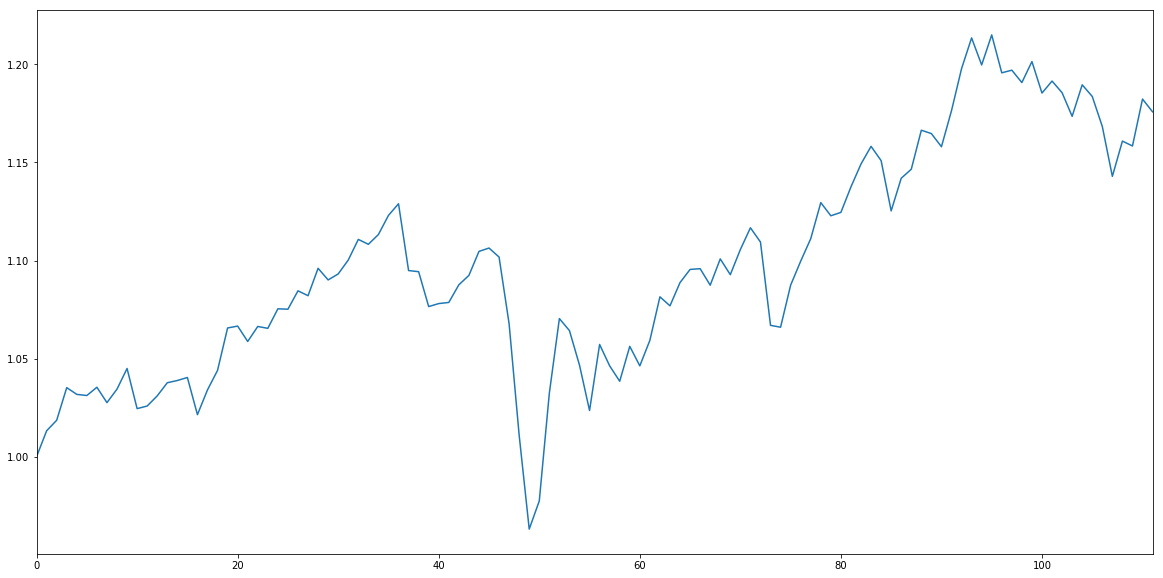

In [70]:
x.iloc[10].plot()

The datasets were successfully generated

# There will be two types of test. One is retraining at every step, and the other is without retraining. The first one is good enough to confirm that there was no overfitting on the hyperparameters. The second can show how "valid" is the model for periods outside the training period. If there is no time dependence in the results, the test without retraining may be the only one perfomed.

In [2]:
best_params_df = pd.read_pickle('../../data/best_params_final_df.pkl')
best_params_df

,GOOD_DATA_RATIO,SAMPLES_GOOD_DATA_RATIO,ahead_days,base_days,model,mre,r2,step_days,train_days,train_val_time,x_filename,y_filename
ahead_days,,,,,,,,,,,,
1.0,0.99,0.9,1.0,112.0,linear,0.015856,0.986599,7.0,504.0,-1.0,x_base112_ahead1.pkl,y_base112_ahead1.pkl
7.0,0.99,0.9,7.0,112.0,linear,0.042367,0.923348,7.0,756.0,-1.0,x_base112_ahead7.pkl,y_base112_ahead7.pkl
14.0,0.99,0.9,14.0,112.0,linear,0.060167,0.865259,7.0,756.0,-1.0,x_base112_ahead14.pkl,y_base112_ahead14.pkl
28.0,0.99,0.9,28.0,112.0,linear,0.091966,0.758046,7.0,756.0,-1.0,x_base112_ahead28.pkl,y_base112_ahead28.pkl
56.0,0.99,0.9,56.0,112.0,linear,0.127913,0.590426,7.0,756.0,-1.0,x_base112_ahead56.pkl,y_base112_ahead56.pkl


## Ahead 1

### Without retraining

Warning: The dates that appear on the samples are the initial dates (there are 112 days ahead after the marked date).

Mean metrics: 
        train      test
r2   0.983486  0.976241
mre  0.008762  0.013906
----------------------------------------------------------------------


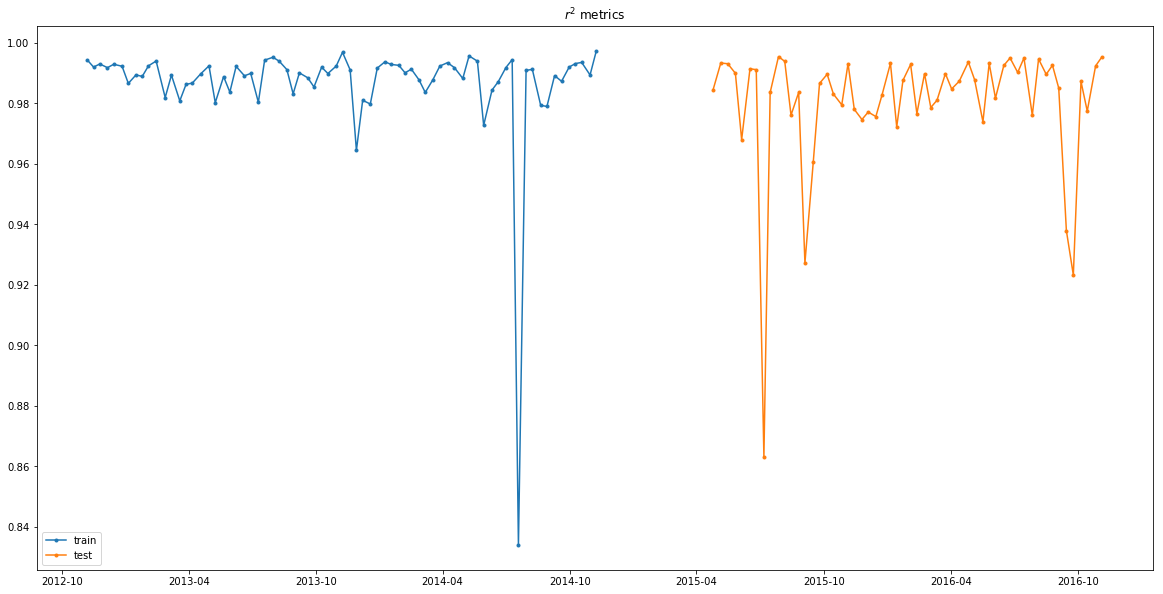

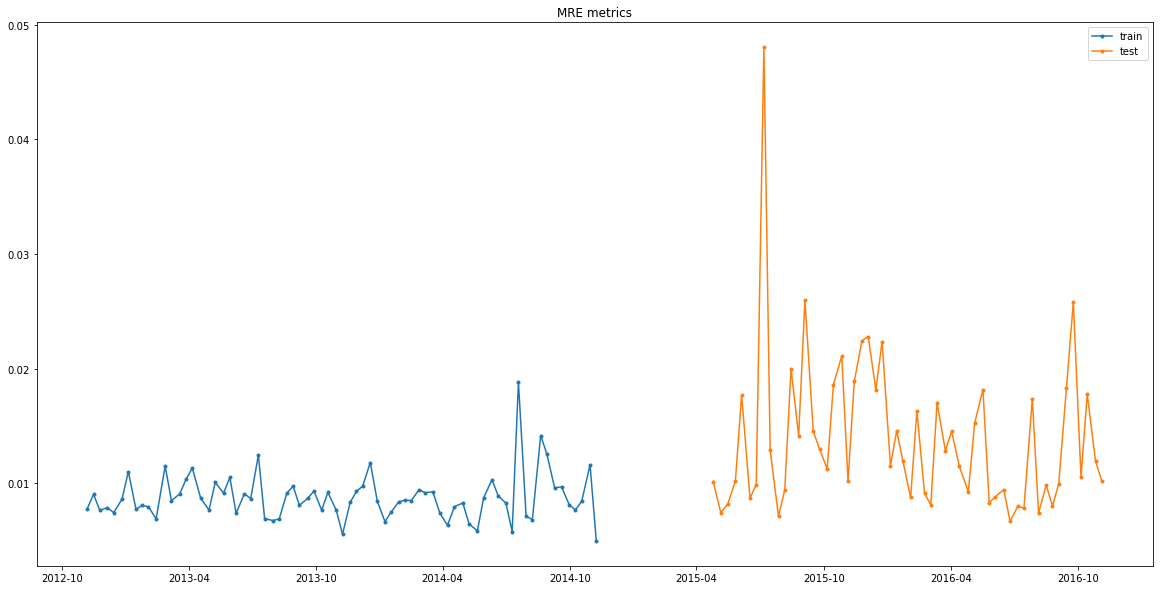

In [59]:
from predictor.linear_predictor import LinearPredictor
import utils.misc as misc
import predictor.evaluation as ev

ahead_days = 1

# Get some parameters
train_days = int(best_params_df.loc[ahead_days, 'train_days'])
GOOD_DATA_RATIO, \
train_val_time, \
base_days, \
step_days, \
ahead_days, \
SAMPLES_GOOD_DATA_RATIO, \
x_filename, \
y_filename = misc.unpack_params(best_params_df.loc[ahead_days,:])

pid = 'base{}_ahead{}'.format(base_days, ahead_days)

# Get the datasets
x_train = pd.read_pickle('../../data/x_{}.pkl'.format(pid))
y_train = pd.read_pickle('../../data/y_{}.pkl'.format(pid))
x_test = pd.read_pickle('../../data/x_{}_test.pkl'.format(pid)).sort_index()
y_test = pd.DataFrame(pd.read_pickle('../../data/y_{}_test.pkl'.format(pid))).sort_index()

# Let's cut the training set to use only the required number of samples
end_date = x_train.index.levels[0][-1]
start_date = fe.add_market_days(end_date, -train_days)
x_sub_df = x_train.loc[(slice(start_date,None),slice(None)),:]
y_sub_df = pd.DataFrame(y_train.loc[(slice(start_date,None),slice(None))])

# Create the estimator and train
estimator = LinearPredictor()
estimator.fit(x_sub_df, y_sub_df)

# Get the training and test predictions
y_train_pred = estimator.predict(x_sub_df)
y_test_pred = estimator.predict(x_test)

# Get the training and test metrics for each symbol
metrics_train = ev.get_metrics_df(y_sub_df, y_train_pred)
metrics_test = ev.get_metrics_df(y_test, y_test_pred)

# Show the mean metrics
metrics_df = pd.DataFrame(columns=['train', 'test'])
metrics_df['train'] = metrics_train.mean()
metrics_df['test'] = metrics_test.mean()
print('Mean metrics: \n{}\n{}'.format(metrics_df,'-'*70))

# Plot the metrics in time
metrics_train_time = ev.get_metrics_in_time(y_sub_df, y_train_pred, base_days + ahead_days)
metrics_test_time = ev.get_metrics_in_time(y_test, y_test_pred, base_days + ahead_days)
plt.plot(metrics_train_time[2], metrics_train_time[0], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[0], label='test', marker='.')
plt.title('$r^2$ metrics')
plt.legend()
plt.figure()
plt.plot(metrics_train_time[2], metrics_train_time[1], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[1], label='test', marker='.')
plt.title('MRE metrics')
plt.legend()

## Ahead 7

Mean metrics: 
        train      test
r2   0.906177  0.874892
mre  0.026232  0.034764
----------------------------------------------------------------------


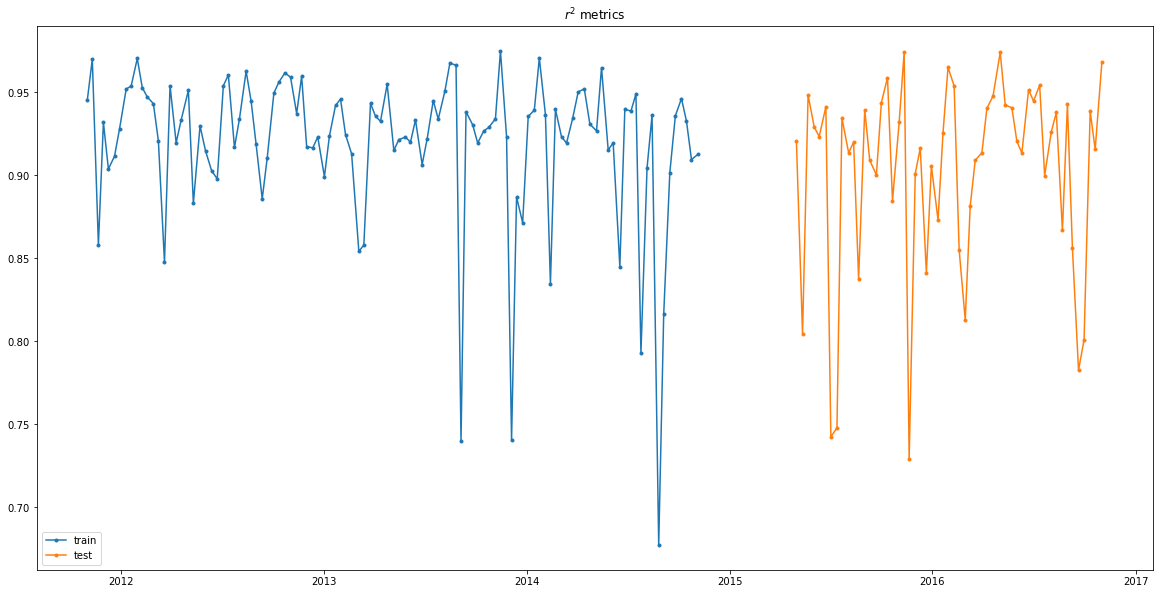

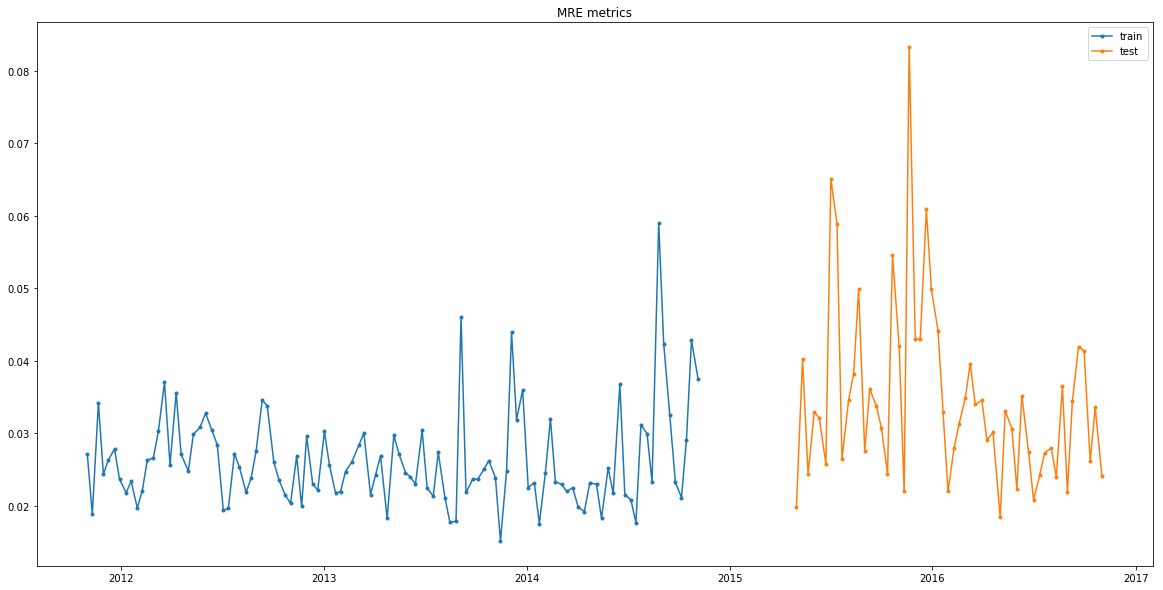

In [60]:
from predictor.linear_predictor import LinearPredictor
import utils.misc as misc
import predictor.evaluation as ev

ahead_days = 7

# Get some parameters
train_days = int(best_params_df.loc[ahead_days, 'train_days'])
GOOD_DATA_RATIO, \
train_val_time, \
base_days, \
step_days, \
ahead_days, \
SAMPLES_GOOD_DATA_RATIO, \
x_filename, \
y_filename = misc.unpack_params(best_params_df.loc[ahead_days,:])

pid = 'base{}_ahead{}'.format(base_days, ahead_days)

# Get the datasets
x_train = pd.read_pickle('../../data/x_{}.pkl'.format(pid))
y_train = pd.read_pickle('../../data/y_{}.pkl'.format(pid))
x_test = pd.read_pickle('../../data/x_{}_test.pkl'.format(pid)).sort_index()
y_test = pd.DataFrame(pd.read_pickle('../../data/y_{}_test.pkl'.format(pid))).sort_index()

# Let's cut the training set to use only the required number of samples
end_date = x_train.index.levels[0][-1]
start_date = fe.add_market_days(end_date, -train_days)
x_sub_df = x_train.loc[(slice(start_date,None),slice(None)),:]
y_sub_df = pd.DataFrame(y_train.loc[(slice(start_date,None),slice(None))])

# Create the estimator and train
estimator = LinearPredictor()
estimator.fit(x_sub_df, y_sub_df)

# Get the training and test predictions
y_train_pred = estimator.predict(x_sub_df)
y_test_pred = estimator.predict(x_test)

# Get the training and test metrics for each symbol
metrics_train = ev.get_metrics_df(y_sub_df, y_train_pred)
metrics_test = ev.get_metrics_df(y_test, y_test_pred)

# Show the mean metrics
metrics_df = pd.DataFrame(columns=['train', 'test'])
metrics_df['train'] = metrics_train.mean()
metrics_df['test'] = metrics_test.mean()
print('Mean metrics: \n{}\n{}'.format(metrics_df,'-'*70))

# Plot the metrics in time
metrics_train_time = ev.get_metrics_in_time(y_sub_df, y_train_pred, base_days + ahead_days)
metrics_test_time = ev.get_metrics_in_time(y_test, y_test_pred, base_days + ahead_days)
plt.plot(metrics_train_time[2], metrics_train_time[0], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[0], label='test', marker='.')
plt.title('$r^2$ metrics')
plt.legend()
plt.figure()
plt.plot(metrics_train_time[2], metrics_train_time[1], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[1], label='test', marker='.')
plt.title('MRE metrics')
plt.legend()

## Ahead 14

Mean metrics: 
        train      test
r2   0.826779  0.758697
mre  0.037349  0.051755
----------------------------------------------------------------------


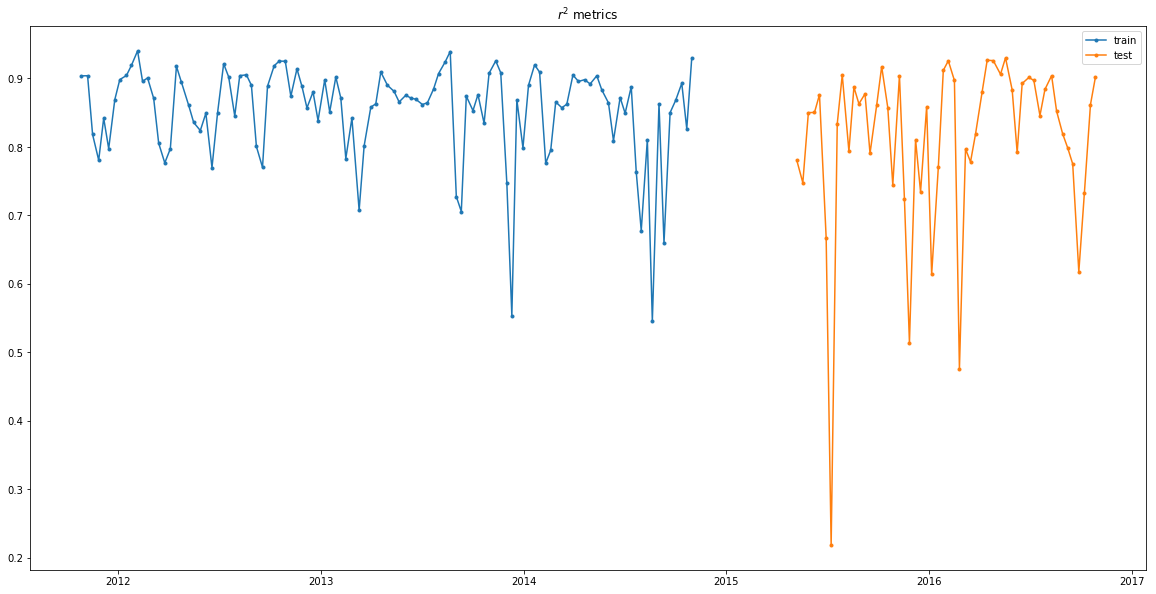

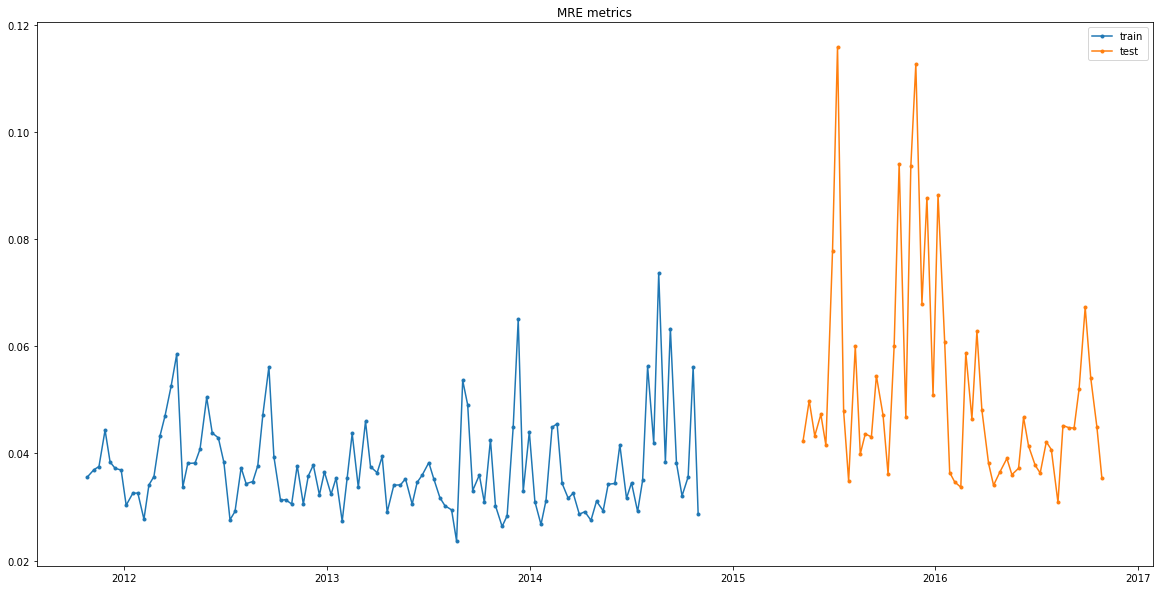

In [61]:
from predictor.linear_predictor import LinearPredictor
import utils.misc as misc
import predictor.evaluation as ev

ahead_days = 14

# Get some parameters
train_days = int(best_params_df.loc[ahead_days, 'train_days'])
GOOD_DATA_RATIO, \
train_val_time, \
base_days, \
step_days, \
ahead_days, \
SAMPLES_GOOD_DATA_RATIO, \
x_filename, \
y_filename = misc.unpack_params(best_params_df.loc[ahead_days,:])

pid = 'base{}_ahead{}'.format(base_days, ahead_days)

# Get the datasets
x_train = pd.read_pickle('../../data/x_{}.pkl'.format(pid))
y_train = pd.read_pickle('../../data/y_{}.pkl'.format(pid))
x_test = pd.read_pickle('../../data/x_{}_test.pkl'.format(pid)).sort_index()
y_test = pd.DataFrame(pd.read_pickle('../../data/y_{}_test.pkl'.format(pid))).sort_index()

# Let's cut the training set to use only the required number of samples
end_date = x_train.index.levels[0][-1]
start_date = fe.add_market_days(end_date, -train_days)
x_sub_df = x_train.loc[(slice(start_date,None),slice(None)),:]
y_sub_df = pd.DataFrame(y_train.loc[(slice(start_date,None),slice(None))])

# Create the estimator and train
estimator = LinearPredictor()
estimator.fit(x_sub_df, y_sub_df)

# Get the training and test predictions
y_train_pred = estimator.predict(x_sub_df)
y_test_pred = estimator.predict(x_test)

# Get the training and test metrics for each symbol
metrics_train = ev.get_metrics_df(y_sub_df, y_train_pred)
metrics_test = ev.get_metrics_df(y_test, y_test_pred)

# Show the mean metrics
metrics_df = pd.DataFrame(columns=['train', 'test'])
metrics_df['train'] = metrics_train.mean()
metrics_df['test'] = metrics_test.mean()
print('Mean metrics: \n{}\n{}'.format(metrics_df,'-'*70))

# Plot the metrics in time
metrics_train_time = ev.get_metrics_in_time(y_sub_df, y_train_pred, base_days + ahead_days)
metrics_test_time = ev.get_metrics_in_time(y_test, y_test_pred, base_days + ahead_days)
plt.plot(metrics_train_time[2], metrics_train_time[0], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[0], label='test', marker='.')
plt.title('$r^2$ metrics')
plt.legend()
plt.figure()
plt.plot(metrics_train_time[2], metrics_train_time[1], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[1], label='test', marker='.')
plt.title('MRE metrics')
plt.legend()

## Ahead 28

Mean metrics: 
        train      test
r2   0.696077  0.515802
mre  0.052396  0.078545
----------------------------------------------------------------------


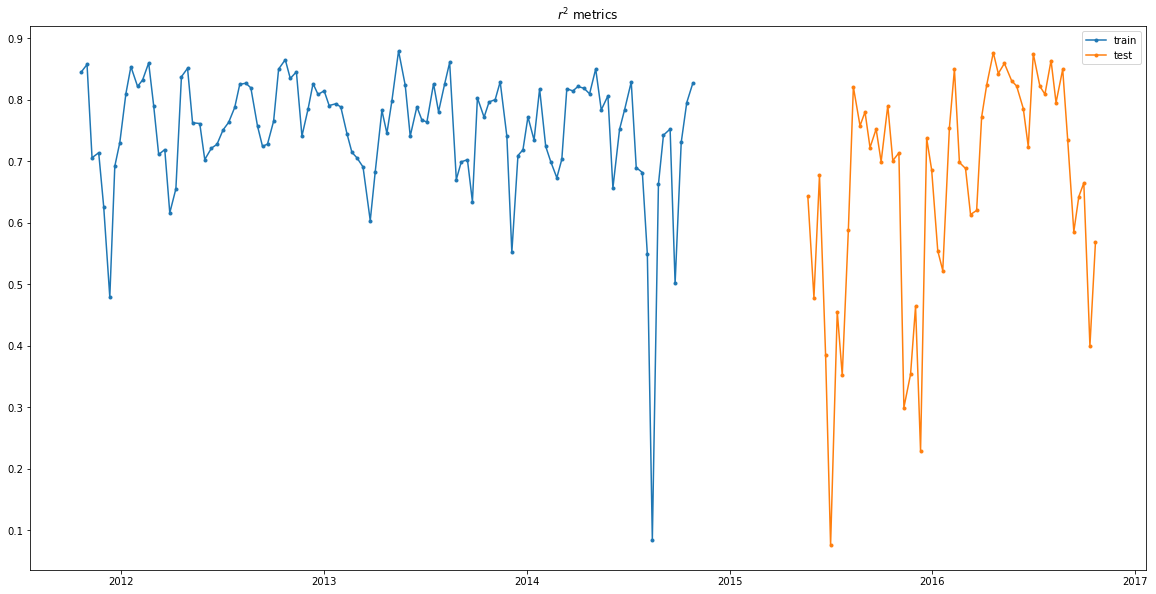

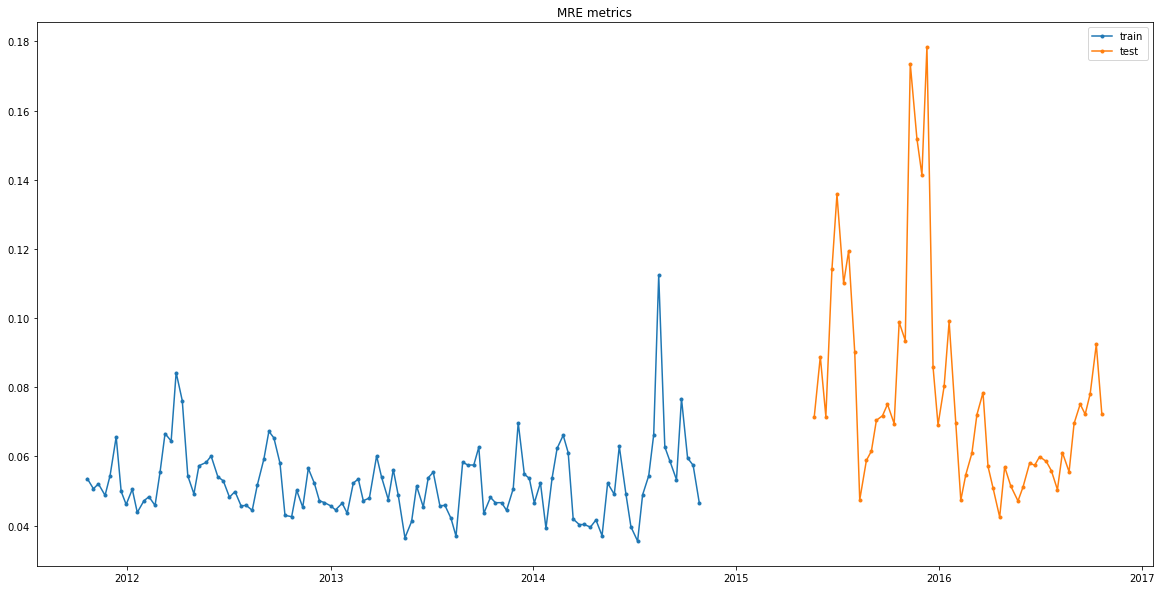

In [62]:
from predictor.linear_predictor import LinearPredictor
import utils.misc as misc
import predictor.evaluation as ev

ahead_days = 28

# Get some parameters
train_days = int(best_params_df.loc[ahead_days, 'train_days'])
GOOD_DATA_RATIO, \
train_val_time, \
base_days, \
step_days, \
ahead_days, \
SAMPLES_GOOD_DATA_RATIO, \
x_filename, \
y_filename = misc.unpack_params(best_params_df.loc[ahead_days,:])

pid = 'base{}_ahead{}'.format(base_days, ahead_days)

# Get the datasets
x_train = pd.read_pickle('../../data/x_{}.pkl'.format(pid))
y_train = pd.read_pickle('../../data/y_{}.pkl'.format(pid))
x_test = pd.read_pickle('../../data/x_{}_test.pkl'.format(pid)).sort_index()
y_test = pd.DataFrame(pd.read_pickle('../../data/y_{}_test.pkl'.format(pid))).sort_index()

# Let's cut the training set to use only the required number of samples
end_date = x_train.index.levels[0][-1]
start_date = fe.add_market_days(end_date, -train_days)
x_sub_df = x_train.loc[(slice(start_date,None),slice(None)),:]
y_sub_df = pd.DataFrame(y_train.loc[(slice(start_date,None),slice(None))])

# Create the estimator and train
estimator = LinearPredictor()
estimator.fit(x_sub_df, y_sub_df)

# Get the training and test predictions
y_train_pred = estimator.predict(x_sub_df)
y_test_pred = estimator.predict(x_test)

# Get the training and test metrics for each symbol
metrics_train = ev.get_metrics_df(y_sub_df, y_train_pred)
metrics_test = ev.get_metrics_df(y_test, y_test_pred)

# Show the mean metrics
metrics_df = pd.DataFrame(columns=['train', 'test'])
metrics_df['train'] = metrics_train.mean()
metrics_df['test'] = metrics_test.mean()
print('Mean metrics: \n{}\n{}'.format(metrics_df,'-'*70))

# Plot the metrics in time
metrics_train_time = ev.get_metrics_in_time(y_sub_df, y_train_pred, base_days + ahead_days)
metrics_test_time = ev.get_metrics_in_time(y_test, y_test_pred, base_days + ahead_days)
plt.plot(metrics_train_time[2], metrics_train_time[0], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[0], label='test', marker='.')
plt.title('$r^2$ metrics')
plt.legend()
plt.figure()
plt.plot(metrics_train_time[2], metrics_train_time[1], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[1], label='test', marker='.')
plt.title('MRE metrics')
plt.legend()

## Ahead 56

Mean metrics: 
        train      test
r2   0.494079  0.152134
mre  0.073589  0.108190
----------------------------------------------------------------------


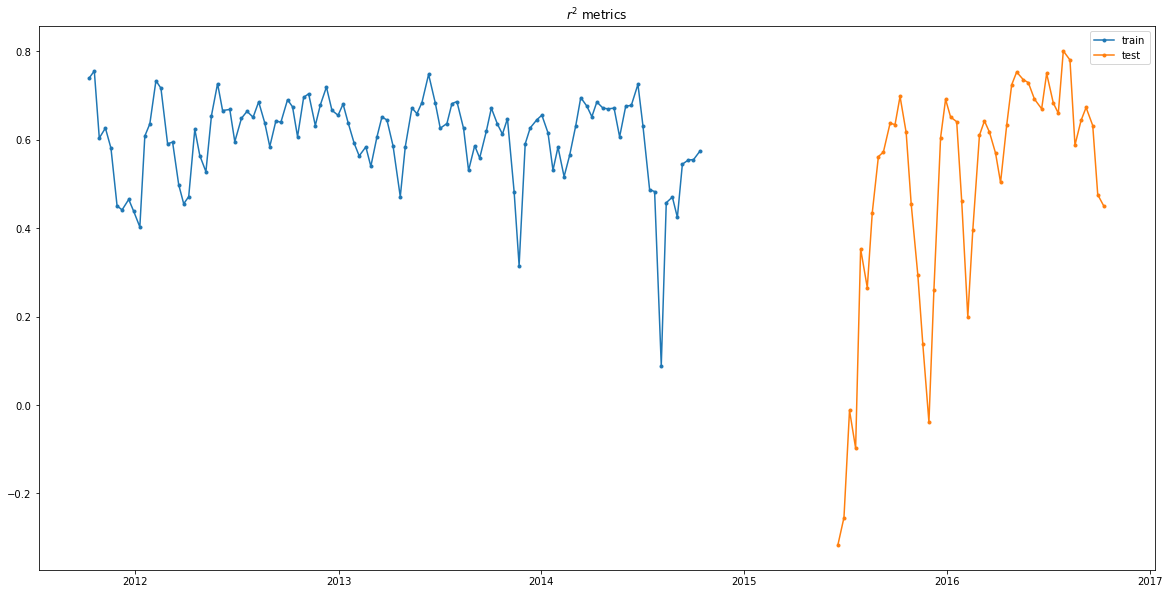

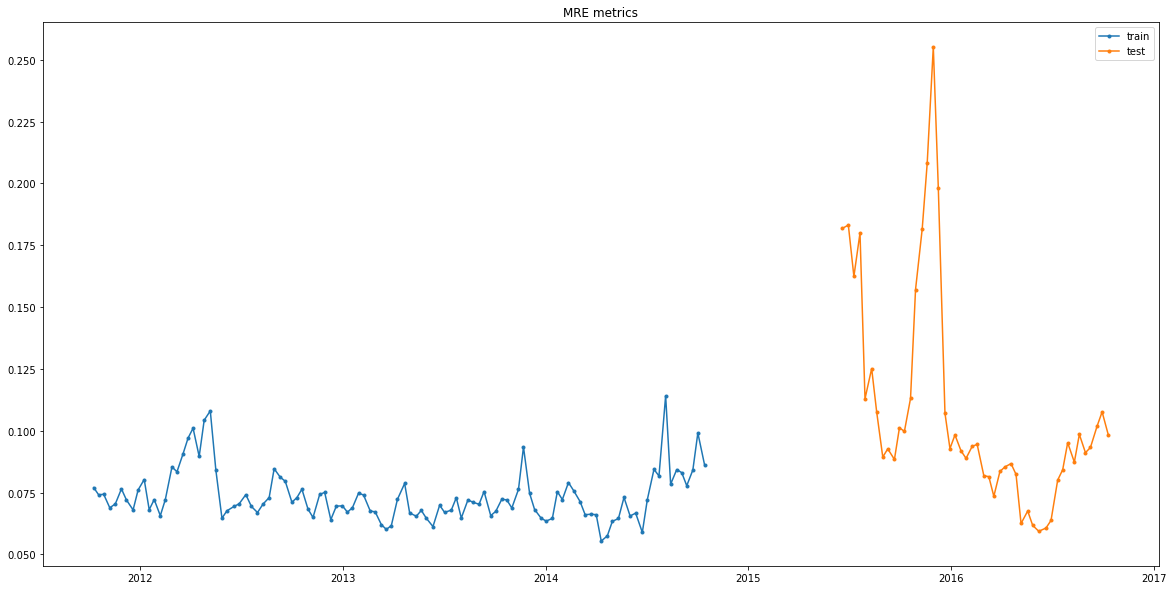

In [63]:
from predictor.linear_predictor import LinearPredictor
import utils.misc as misc
import predictor.evaluation as ev

ahead_days = 56

# Get some parameters
train_days = int(best_params_df.loc[ahead_days, 'train_days'])
GOOD_DATA_RATIO, \
train_val_time, \
base_days, \
step_days, \
ahead_days, \
SAMPLES_GOOD_DATA_RATIO, \
x_filename, \
y_filename = misc.unpack_params(best_params_df.loc[ahead_days,:])

pid = 'base{}_ahead{}'.format(base_days, ahead_days)

# Get the datasets
x_train = pd.read_pickle('../../data/x_{}.pkl'.format(pid))
y_train = pd.read_pickle('../../data/y_{}.pkl'.format(pid))
x_test = pd.read_pickle('../../data/x_{}_test.pkl'.format(pid)).sort_index()
y_test = pd.DataFrame(pd.read_pickle('../../data/y_{}_test.pkl'.format(pid))).sort_index()

# Let's cut the training set to use only the required number of samples
end_date = x_train.index.levels[0][-1]
start_date = fe.add_market_days(end_date, -train_days)
x_sub_df = x_train.loc[(slice(start_date,None),slice(None)),:]
y_sub_df = pd.DataFrame(y_train.loc[(slice(start_date,None),slice(None))])

# Create the estimator and train
estimator = LinearPredictor()
estimator.fit(x_sub_df, y_sub_df)

# Get the training and test predictions
y_train_pred = estimator.predict(x_sub_df)
y_test_pred = estimator.predict(x_test)

# Get the training and test metrics for each symbol
metrics_train = ev.get_metrics_df(y_sub_df, y_train_pred)
metrics_test = ev.get_metrics_df(y_test, y_test_pred)

# Show the mean metrics
metrics_df = pd.DataFrame(columns=['train', 'test'])
metrics_df['train'] = metrics_train.mean()
metrics_df['test'] = metrics_test.mean()
print('Mean metrics: \n{}\n{}'.format(metrics_df,'-'*70))

# Plot the metrics in time
metrics_train_time = ev.get_metrics_in_time(y_sub_df, y_train_pred, base_days + ahead_days)
metrics_test_time = ev.get_metrics_in_time(y_test, y_test_pred, base_days + ahead_days)
plt.plot(metrics_train_time[2], metrics_train_time[0], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[0], label='test', marker='.')
plt.title('$r^2$ metrics')
plt.legend()
plt.figure()
plt.plot(metrics_train_time[2], metrics_train_time[1], label='train', marker='.')
plt.plot(metrics_test_time[2], metrics_test_time[1], label='test', marker='.')
plt.title('MRE metrics')
plt.legend()

## Conclusion: The metrics are a bit worse for the test set, as expected, but it seems to be reasonably close. There is no clear tendency in time, so a "time validity" for the model couldn't be found within the studied periods.

### NOTE: A gap can be seen in the dates between the training and test sets. That is due to using only test samples that have test features (x) and labels (y). It would be acceptable to use features in the training set to predict labels in the test set. In this case, it was considered that, since the studied case is even more restrictive than the other one, no training features with labels in the test set were used.